### Build local cache file from Argo data sources
*Execute commands to pull data from the Internet into a local HDF cache file so that we can better interact with the data*

On a development system (where we have not executed a `pip install oxyfloat`) we need to add the oxyfloat directory to the Python search path. Do this before starting the notebook server with (replace `~/dev/oxyfloatgit/` with the directory where you cloned the oxyfloat project):

```bash
export PYTHONPATH=~/dev/oxyfloatgit/
cd ~/dev/oxyfloatgit/notebooks
ipython notebook
```

Alternatively, you can set the path interactively, e.g.:

In [1]:
import sys
sys.path.insert(0, 'C:\Users\saca\Documents\GitHub\oxyfloat')

Import the OxyFloat class and instatiate an OxyFloat object (`of`) with verbosity set to 2 so that we get INFO messages.

In [2]:
from oxyfloat import OxyFloat
of = OxyFloat(verbosity=2)

You can now explore what methods the of object has by typing "`of.`" in a cell and pressing the tab key. One of the methods is `get_oxy_floats()`; to see what it does select it and press shift-tab with the cursor in the parentheses of "`of.get_oxy_floats()`". Let's get a list of all the floats that have been out for at least 340 days and print the length of that list.

In [3]:
%%time
floats340 = of.get_oxy_floats_from_status(age_gte=340)
print('{} floats at least 340 days old'.format(len(floats340)))

INFO:root:Reading data from http://argo.jcommops.org/FTPRoot/Argo/Status/argo_all.txt
INFO:requests.packages.urllib3.connectionpool:Starting new HTTP connection (1): argo.jcommops.org
INFO:root:Saving DataFrame to name "status" in file /home/mccann/dev/oxyfloatgit/oxyfloat/oxyfloat_cache.hdf


563 floats at least 340 days old
CPU times: user 298 ms, sys: 196 ms, total: 494 ms
Wall time: 21.2 s


/home/mccann/dev/oxyfloatgit/oxyfloat/OxyFloat.py:184: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->['WMO', 'TELECOM', 'TTYPE', 'MY_ID', 'SERIAL_NO', 'DATE0', 'NOTIF_DATE', 'SHIP', 'CRUISE', 'DATE_', 'MODEL', 'FULL_NAME', 'EMAIL', 'PROGRAM', 'COUNTRY']]

  self._put_df(self._status_to_df(), self._STATUS)


If this the first time you've executed the cell it will take minute or so to read the Argo status information from the Internet (the PerformanceWarning can be ignored - for this small table it doesn't matter much). 

Once the status information is read it is cached locally and further calls to `get_oxy_floats_from_status()` will execute much faster. To demonstrate, let's count all the oxygen labeled floats that have been out for at least 2 years. 

In [4]:
%%time
floats730 = of.get_oxy_floats_from_status(age_gte=730)
print('{} floats at least 730 days old'.format(len(floats730)))

400 floats at least 730 days old
CPU times: user 33 ms, sys: 0 ns, total: 33 ms
Wall time: 62.9 ms


Now let's find the Data Assembly Center URL for each of the floats in our list. (The returned dictionary of URLs is also locally cached.)

In [5]:
%%time
dac_urls = of.get_dac_urls(floats340)
print(len(dac_urls))

INFO:root:Reading data from ftp://ftp.ifremer.fr/ifremer/argo/ar_index_global_meta.txt
INFO:root:Saving DataFrame to name "global_meta" in file /home/mccann/dev/oxyfloatgit/oxyfloat/oxyfloat_cache.hdf


562
CPU times: user 832 ms, sys: 18 ms, total: 850 ms
Wall time: 4.87 s


Now, whenever we need to get profile data our lookups for status and Data Assembly Centers will be serviced from the local cache. Let's get a Pandas DataFrame (`df`) of 20 profiles from the float with WMO number 1900650.

In [6]:
%%time
wmo_list = ['1900650']
of.set_verbosity(0)
df = of.get_float_dataframe(wmo_list, max_profiles=20)

CPU times: user 2.51 s, sys: 224 ms, total: 2.74 s
Wall time: 1min 39s


Profile data is also cached locally. To demonstrate, perform the same command as in the previous cell and note the time difference.

In [7]:
%%time
df = of.get_float_dataframe(wmo_list, max_profiles=20)

CPU times: user 897 ms, sys: 7 ms, total: 904 ms
Wall time: 2.04 s


Examine the first 5 records of the float data.

In [8]:
df.head()

DOXY_ADJUSTED  \
wmo     time                lon     lat   pressure                  
1900650 2010-03-11T17:39:40 -14.026 6.031 4.3          206.490005   
                                          5.9          206.380005   
                                          9.1          206.300003   
                                          13.9         206.850006   
                                          19.5         206.860001   

                                                    PSAL_ADJUSTED  \
wmo     time                lon     lat   pressure                  
1900650 2010-03-11T17:39:40 -14.026 6.031 4.3           34.827457   
                                          5.9           34.827457   
                                          9.1           34.827457   
                                          13.9          34.826454   
                                          19.5          34.847443   

                                                    TEMP_ADJUSTED  
wmo     time                lon     lat   pressure                 
1900650 2010-03-11T17:39:40 -14.026 6.031 4.3           29.790001  
                                          5.9           29.789000  
                                          9.1           29.790001  
                                          13.9          29.787001  
                                          19.5          29.681999

There's a lot that can be done with the profile data in this DataFrame structure. We can construct a `time_range` string and query for all the data values from less than 10 decibars:

In [9]:
time_range = '{} to {}'.format(df.index.get_level_values('time').min(), 
                               df.index.get_level_values('time').max())
df.query('pressure < 10')

DOXY_ADJUSTED  \
wmo     time                lon     lat   pressure                  
1900650 2010-03-11T17:39:40 -14.026 6.031 4.3          206.490005   
                                          5.9          206.380005   
                                          9.1          206.300003   
        2010-02-19T17:52:38 -14.866 5.551 4.5          204.110001   
                                          6.3          204.399994   
                                          9.2          204.110001   
        2010-02-09T17:57:26 -14.929 5.492 4.5          190.630005   
                                          6.2          190.190002   
                                          9.4          187.940002   
        2010-01-30T17:02:30 -15.038 5.725 4.4          195.669998   
                                          6.4          194.520004   
                                          9.5          192.750000   
        2010-01-20T18:05:11 -15.077 5.719 4.6          198.949997   
                                          6.4          198.880005   
                                          9.2          199.139999   
        2010-01-10T17:07:43 -15.128 5.117 4.5          199.960007   
                                          6.2          199.539993   
                                          9.1          199.520004   
        2009-12-31T17:10:18 -15.162 5.184 4.4          181.919998   
                                          6.0          181.240005   
                                          8.8          179.059998   
        2009-12-21T17:12:05 -15.207 5.685 4.8          117.779999   
                                          6.7          133.360001   
                                          9.5          177.119995   
        2009-12-11T15:35:43 -15.374 5.600 4.3          165.770004   
                                          6.1          163.679993   
                                          9.0          159.630005   
        2009-12-01T15:41:39 -15.373 6.082 4.5          145.250000   
                                          6.3          142.309998   
                                          9.2          138.949997   
...                                                           ...   
        2009-11-11T15:15:41 -15.862 6.140 4.6          129.660004   
                                          6.4          124.559998   
                                          9.2          116.660004   
        2009-11-01T18:46:59 -16.458 5.963 4.0          148.809998   
                                          6.2          145.509995   
                                          9.2          140.770004   
        2009-10-22T18:23:59 -16.597 5.742 4.7           43.430000   
                                          6.2           44.910000   
                                          9.0           64.629997   
        2009-10-12T20:00:00 -16.724 5.618 4.4          161.570007   
                                          6.3          160.309998   
                                          9.3          158.979996   
        2009-10-02T16:46:59 -17.357 5.626 4.6          183.649994   
                                          6.2          182.570007   
                                          8.9          181.380005   
        2009-09-22T18:30:00 -17.463 6.054 4.2          192.330002   
                                          6.0          191.320007   
                                          9.0          191.229996   
        2009-09-12T16:12:59 -17.252 7.049 4.1          202.529999   
                                          6.1          202.009995   
                                          8.8          201.490005   
        2009-09-02T18:39:59 -17.122 7.552 4.4          200.639999   
                                          6.0          200.589996   
                                          9.0          200.229996   
        2009-08-23T18:36:59 -17.952 7.558 4.3          196.679993   
                                          6.1     

In one command we can take the mean of all the values from the upper 10 decibars:

In [10]:
df.query('pressure < 10').groupby(level=['wmo', 'time']).mean()

DOXY_ADJUSTED  PSAL_ADJUSTED  TEMP_ADJUSTED
wmo     time                                                            
1900650 2009-08-13T18:38:00     194.656667      35.160473      26.906000
        2009-08-23T18:36:59     196.166667      34.635293      27.175667
        2009-09-02T18:39:59     200.486664      34.633526      27.277000
        2009-09-12T16:12:59     202.010000      35.077201      27.115334
        2009-09-22T18:30:00     191.626668      34.910834      27.465333
        2009-10-02T16:46:59     182.533335      34.813449      27.766000
        2009-10-12T20:00:00     160.286667      34.566499      28.086333
        2009-10-22T18:23:59      50.989999      34.757608      28.383000
        2009-11-01T18:46:59     145.029999      34.667896      28.403667
        2009-11-11T15:15:41     123.626668      34.569499      28.786667
        2009-11-21T17:18:26     118.360001      34.545078      29.077667
        2009-12-01T15:41:39     142.169998      34.523666      28.471667
        2009-12-11T15:35:43     163.026667      34.810046      28.672667
        2009-12-21T17:12:05     142.753332      33.912081      29.030333
        2009-12-31T17:10:18     180.740000      34.332881      28.845667
        2010-01-10T17:07:43     199.673335      34.392058      29.048000
        2010-01-20T18:05:11     198.990000      35.032192      29.036000
        2010-01-30T17:02:30     194.313334      34.679620      29.146333
        2010-02-09T17:57:26     189.586670      34.772458      29.654667
        2010-02-19T17:52:38     204.206665      35.151833      29.461000
        2010-03-11T17:39:40     206.390004      34.827457      29.789667

We can plot the profiles:

Populating the interactive namespace from numpy and matplotlib


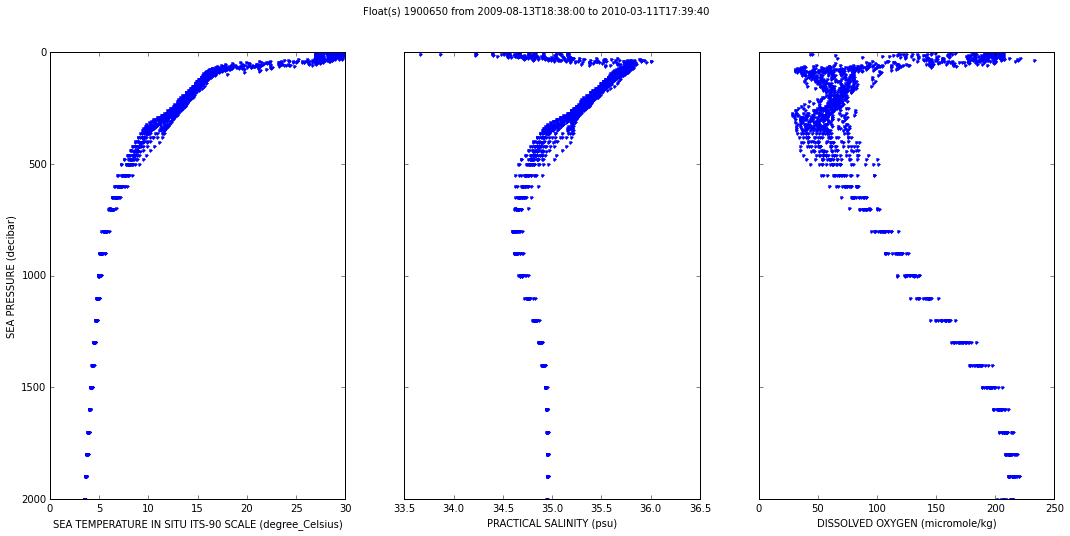

In [11]:
%pylab inline
import pylab as plt
# Parameter long_name and units copied from attributes in NetCDF files
parms = {'TEMP_ADJUSTED': 'SEA TEMPERATURE IN SITU ITS-90 SCALE (degree_Celsius)', 
         'PSAL_ADJUSTED': 'PRACTICAL SALINITY (psu)',
         'DOXY_ADJUSTED': 'DISSOLVED OXYGEN (micromole/kg)'}

plt.rcParams['figure.figsize'] = (18.0, 8.0)
fig, ax = plt.subplots(1, len(parms), sharey=True)
ax[0].invert_yaxis()
ax[0].set_ylabel('SEA PRESSURE (decibar)')

for i, (p, label) in enumerate(parms.iteritems()):
    ax[i].set_xlabel(label)
    ax[i].plot(df[p], df.index.get_level_values('pressure'), '.')
    
plt.suptitle('Float(s) ' + ' '.join(wmo_list) + ' from ' + time_range)

We can plot the location of these profiles on a map:

/home/mccann/VirtualEnvs/oxyfloat/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


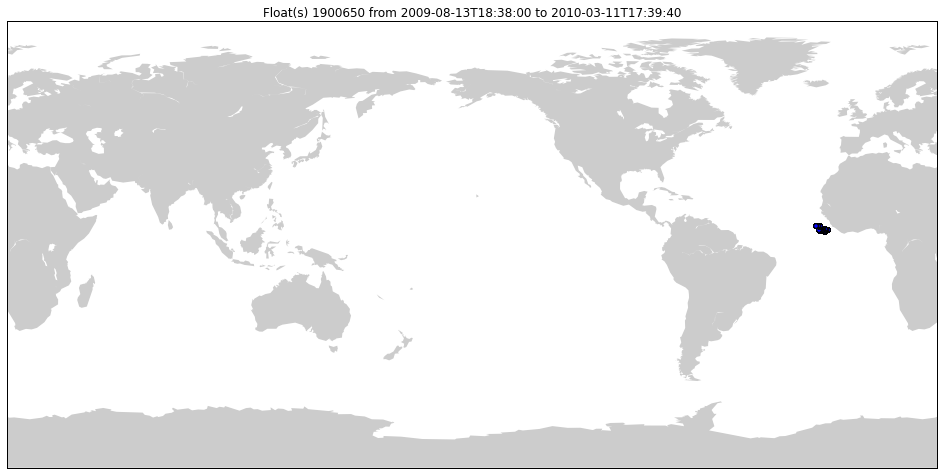

In [12]:
from mpl_toolkits.basemap import Basemap

m = Basemap(llcrnrlon=15, llcrnrlat=-90, urcrnrlon=390, urcrnrlat=90, projection='cyl')
m.fillcontinents(color='0.8')

m.scatter(df.index.get_level_values('lon'), df.index.get_level_values('lat'), latlon=True)
plt.title('Float(s) ' + ' '.join(wmo_list) + ' from ' + time_range)